In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/107.7 GB disk)


In [ ]:
from ultralytics import YOLO
import os

Executando inferência em: 00007256_in.jpg

image 1/1 /content/drive/MyDrive/dataset_back/images/test/00007256_in.jpg: 480x640 1 numero, 1 codigo, 1 numero_lateral, 1 local, 1 data_emissao, 1 assinatura_emissor, 276.3ms
Speed: 6.3ms preprocess, 276.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)
Executando inferência em: 00007257_in.jpg

image 1/1 /content/drive/MyDrive/dataset_back/images/test/00007257_in.jpg: 448x640 1 numero, 1 codigo, 1 numero_lateral, 1 local, 1 data_emissao, 1 assinatura_emissor, 252.3ms
Speed: 4.6ms preprocess, 252.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)
Executando inferência em: 00007258_in.jpg

image 1/1 /content/drive/MyDrive/dataset_back/images/test/00007258_in.jpg: 480x640 1 numero, 1 codigo, 1 numero_lateral, 1 local, 1 data_emissao, 1 assinatura_emissor, 1 observacoes, 172.2ms
Speed: 3.4ms preprocess, 172.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Executando inferência em: 00007259

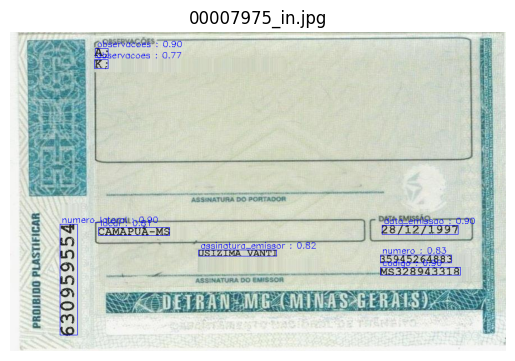

In [ ]:
import os
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import random
from PIL import Image
from collections import defaultdict

model = YOLO('/content/drive/MyDrive/dataset_back/best.pt')

test_set_loc = '/content/drive/MyDrive/dataset_back/images/test/'
output_crop_dir = '/content/drive/MyDrive/crops_Yolo_back/'


os.makedirs(output_crop_dir, exist_ok=True)

def checkClass(name):
    if name == 'numero':
        return 0
    elif name == 'codigo':
        return 1
    elif name == 'numero_lateral':
        return 2
    elif name == 'local':
        return 3
    elif name == 'data_emissao':
        return 4
    elif name == 'assinatura_emissor':
        return 5
    elif name == 'observacoes':
        return 6
    else:
        return -1

def plot_and_crop_bboxes(results, image_path):
    img = results[0].orig_img
    img_rgb = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    names = results[0].names
    scores = results[0].boxes.conf.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)

    base_name = os.path.splitext(os.path.basename(image_path))[0].replace('_in', '')
    output_dir = os.path.join(output_crop_dir, base_name)
    os.makedirs(output_dir, exist_ok=True)

    detections = []
    for score, cls, bbox in zip(scores, classes, boxes):
        class_label = names[int(cls)]
        class_id = checkClass(class_label)
        if class_id == -1:
            continue

        detections.append({
            'score': score,
            'class_label': class_label,
            'class_id': class_id,
            'bbox': bbox
        })

    grouped = defaultdict(list)
    for det in detections:
        grouped[det['class_id']].append(det)

    for class_id in grouped:
        grouped[class_id].sort(key=lambda d: d['bbox'][0])

    output_img_rgb = img_rgb.copy()

    for class_id, det_list in grouped.items():
        for i, det in enumerate(det_list):
            score = det['score']
            class_label = det['class_label']
            bbox = det['bbox']

            x_min, y_min, x_max, y_max = bbox
            left = max(x_min - 5, 0)
            top = max(y_min - 2, 0)
            right = min(x_max + 2, img.shape[1])
            bottom = min(y_max + 2, img.shape[0])

            crop = img[top:bottom, left:right]

            cropped_image = Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

            if class_id == 2:
                cropped_image = cropped_image.rotate(270, expand=True)

            save_path = os.path.join(output_dir, f"{class_id}.{i+1}.jpg")
            cropped_image.save(save_path)

            output_img_rgb = cv2.rectangle(output_img_rgb, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0,0,255), 1)
            label = f"{class_label} : {score:.2f}"
            cv2.putText(output_img_rgb, label, (bbox[0]+3, bbox[1]-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)

    return output_img_rgb

for filename in os.listdir(test_set_loc):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(test_set_loc, filename)
        print("Executando inferência em:", filename)

        results = model(image_path, conf=0.5, iou=0.1)
        img_with_boxes = plot_and_crop_bboxes(results, image_path)

        plt.imshow(img_with_boxes)
        plt.axis('off')
        plt.title(filename)
        # plt.show()